In [57]:
import scipy.io
import cv2
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import shutil

In [34]:
def plot_side_by_side(img_1, img_2, title1="Original Image", title2="Processed Image"):
    """
    A function to plot two images side by side.
    """
    # if len(img_1.shape) == 3 or len(img_2.shape) == 3:
    #     img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
    #     img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].imshow(img_1, cmap='gray')
    axs[1].imshow(img_2, cmap='gray')

    axs[0].set_title(title1)
    axs[1].set_title(title2)

In [99]:
train_images = []
train_annotations = []
train_folder = "Train"

for filename in os.listdir(train_folder):
    if filename.endswith(".jpg"):
        image_path = os.path.join(train_folder, filename)
        train_images.append(image_path)
    elif filename.endswith(".mat"):
        image_path = os.path.join(train_folder, filename)
        train_annotations.append(image_path)

print("Number of images: ", len(train_images))
print("Number of annotations: ", len(train_annotations))

Number of images:  1201
Number of annotations:  1201


In [51]:
def visualize_annotations(image_path, annotation_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert for matplotlib

    # Load annotations
    mat = scipy.io.loadmat(annotation_path)
    points = mat["annPoints"]

    # Plot image and points
    plt.imshow(image)
    if points.shape[1] == 2:
        plt.scatter(points[:, 0], points[:, 1], color='red', s=5)
    plt.show()

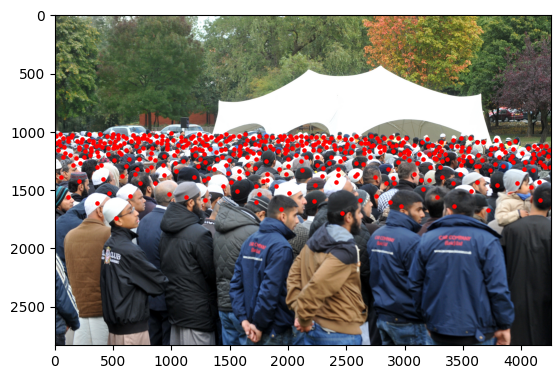

In [29]:
visualize_annotations(train_images[0], train_annotations[0])

In [100]:
def add_noise(image, noise_type="gaussian"):
    """Adds noise to an image."""
    if noise_type == "gaussian":
        mean, stddev = 0, 5  # Mean and standard deviation for Gaussian noise
        noise = np.random.normal(mean, stddev, image.shape).astype(np.uint8)
        noisy_image = cv2.add(image, noise)  # Add noise to image
    
    elif noise_type == "salt_pepper":
        prob = 0.02  # Probability of noise
        noisy_image = np.copy(image)
        black = 0
        white = 255
        
        # Apply salt & pepper noise
        num_pixels = int(prob * image.size)
        for _ in range(num_pixels // 2):
            x, y = random.randint(0, image.shape[1] - 1), random.randint(0, image.shape[0] - 1)
            noisy_image[y, x] = black
            x, y = random.randint(0, image.shape[1] - 1), random.randint(0, image.shape[0] - 1)
            noisy_image[y, x] = white

    elif noise_type == "poisson":
        noisy_image = np.random.poisson(image.astype(np.float32) * 1.0)  # Poisson noise
        noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    
    else:
        noisy_image = image  # No noise if invalid type
    
    return noisy_image


def generate_random_crops(image_path, annotation_path, save_dir, crop_size=(1024, 1024), num_crops=4, train=True, seed=42):
    random.seed(seed)
    image = cv2.imread(image_path)
    h, w, _ = image.shape
    
    mat = scipy.io.loadmat(annotation_path)
    points = mat["annPoints"] 
    
    os.makedirs(save_dir, exist_ok=True)
    image_name = os.path.splitext(os.path.basename(image_path))[0]

    # If image is smaller than target size, pad it
    if h < crop_size[1] or w < crop_size[0]:
        pad_h = max(0, crop_size[1] - h)
        pad_w = max(0, crop_size[0] - w)
        image = cv2.copyMakeBorder(image, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=(0, 0, 0))
        points = np.array([[x, y] for x, y in points])  # No need to adjust points, as padding doesn't shift them
        h, w, _ = image.shape
    
    for i in range(num_crops):
        crop_x = random.randint(0, w - crop_size[0])
        crop_y = random.randint(0, h - crop_size[1])
        
        cropped_image = image[crop_y:crop_y + crop_size[1], crop_x:crop_x + crop_size[0]]
        
        # Keep only annotations inside the cropped region
        cropped_points = np.array([[x - crop_x, y - crop_y] for x, y in points 
                                   if crop_x <= x < crop_x + crop_size[0] and crop_y <= y < crop_y + crop_size[1]])
        
        if train:
            if random.random() < 0.5:
                noise_type = random.choice(["gaussian", "salt_pepper", "poisson"])
                cropped_image = add_noise(cropped_image, noise_type)
        
        # Save cropped image
        crop_image_path = os.path.join(save_dir, f"{image_name}_crop_{i}.jpg")
        save_resized_image_and_annotations(cropped_image, cropped_points, crop_image_path, crop_image_path.replace(".jpg", ".mat"))


def save_resized_image_and_annotations(resized_image, resized_points, save_path_image, save_path_annotation):
    # Save resized image
    cv2.imwrite(save_path_image, resized_image)

    # Save resized annotations in .mat format
    annotation_dict = {"annPoints": resized_points}  # Store points in dictionary
    scipy.io.savemat(save_path_annotation, annotation_dict)


# Resize all images and annotations

target_size = (1024, 1024)

for image_path, annotation_path in zip(train_images, train_annotations):
    generate_random_crops(image_path, annotation_path, "Train_resized", crop_size=target_size, num_crops=4)


In [94]:
train_resized_images = []
train_resized_annotations = []
train_resized_folder = "Train_resized"

for filename in os.listdir(train_resized_folder):
    if filename.endswith(".jpg"):
        image_path = os.path.join(train_resized_folder, filename)
        train_resized_images.append(image_path)
    elif filename.endswith(".mat"):
        image_path = os.path.join(train_resized_folder, filename)
        train_resized_annotations.append(image_path)

print("Number of images: ", len(train_resized_images))
print("Number of annotations: ", len(train_resized_annotations))

Number of images:  4804
Number of annotations:  4804


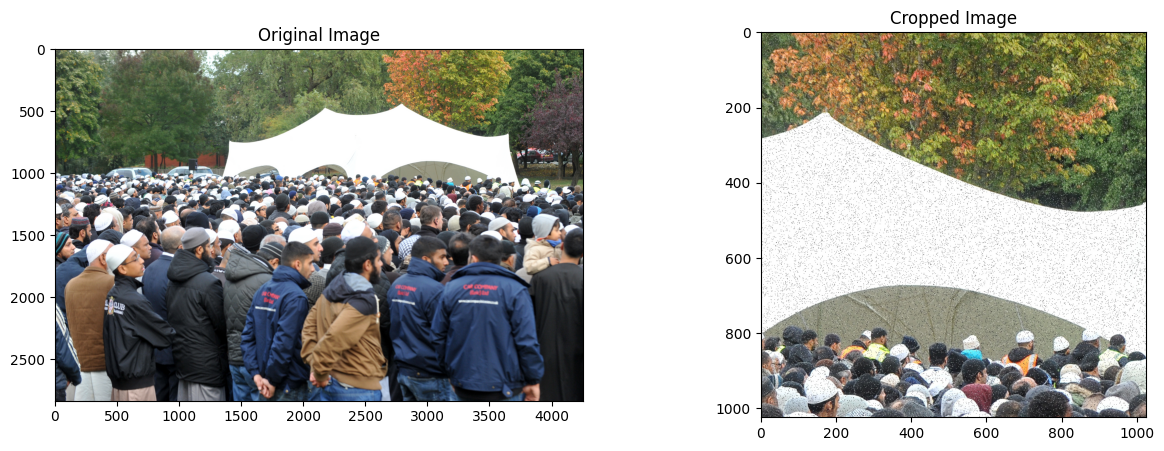

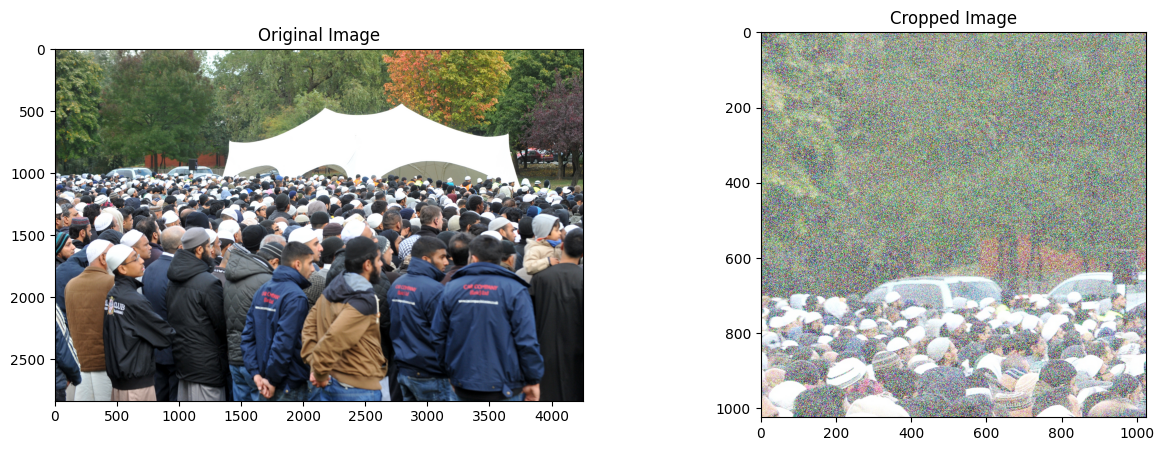

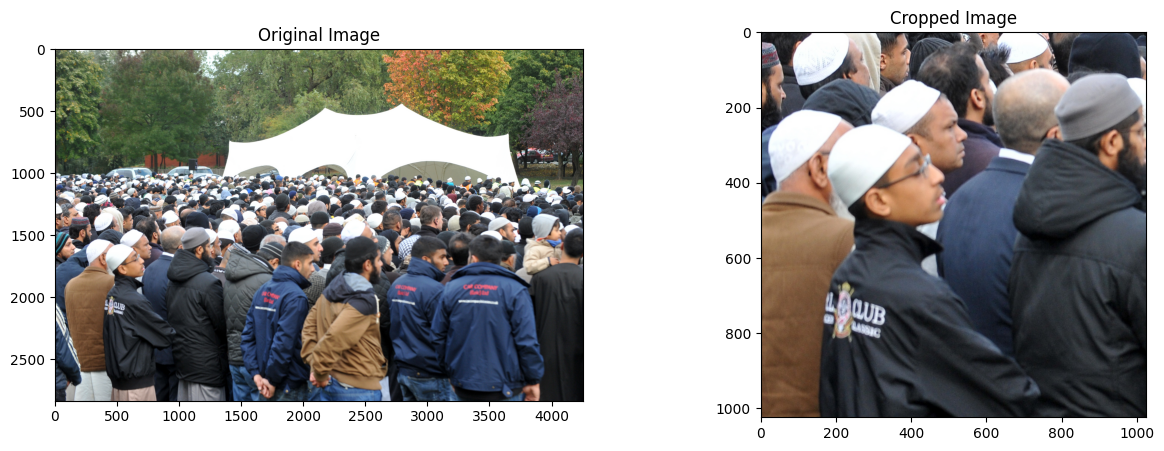

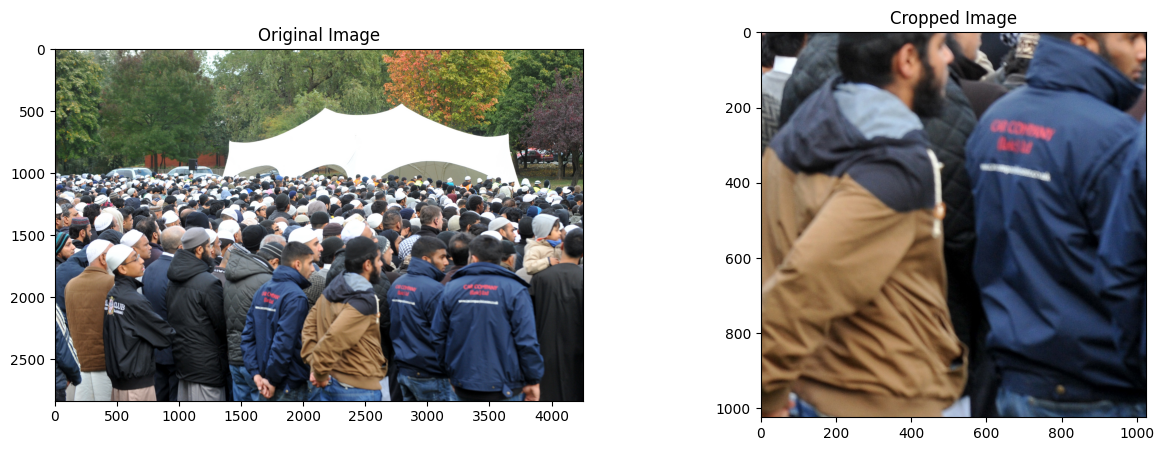

In [59]:
plot_side_by_side(cv2.cvtColor(cv2.imread(train_images[0]), cv2.COLOR_BGR2RGB), cv2.cvtColor(cv2.imread(train_resized_images[0]), cv2.COLOR_BGR2RGB), title1="Original Image", title2="Cropped Image")
plot_side_by_side(cv2.cvtColor(cv2.imread(train_images[0]), cv2.COLOR_BGR2RGB), cv2.cvtColor(cv2.imread(train_resized_images[1]), cv2.COLOR_BGR2RGB), title1="Original Image", title2="Cropped Image")
plot_side_by_side(cv2.cvtColor(cv2.imread(train_images[0]), cv2.COLOR_BGR2RGB), cv2.cvtColor(cv2.imread(train_resized_images[2]), cv2.COLOR_BGR2RGB), title1="Original Image", title2="Cropped Image")
plot_side_by_side(cv2.cvtColor(cv2.imread(train_images[0]), cv2.COLOR_BGR2RGB), cv2.cvtColor(cv2.imread(train_resized_images[3]), cv2.COLOR_BGR2RGB), title1="Original Image", title2="Cropped Image")

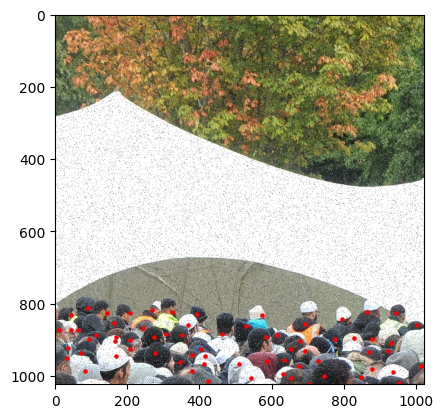

In [60]:
visualize_annotations(train_resized_images[0], train_resized_annotations[0])

Now we need to apply random croppping to Test and Validation sets

We need to split test set to both validation and test parts

In [70]:
def split_test_set(test_dir, val_dir, final_test_dir, split_ratio=0.5, seed=42):
    random.seed(seed)

    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(final_test_dir, exist_ok=True)

    all_images = [f for f in os.listdir(test_dir) if f.endswith(('.jpg', '.png'))]
    random.shuffle(all_images)

    split_point = int(len(all_images) * split_ratio)
    val_images = all_images[:split_point]
    test_images = all_images[split_point:]

    def move_files(image_list, dest_dir):
        for img in image_list:
            img_path = os.path.join(test_dir, img)
            mat_path = os.path.join(test_dir, img.replace('.jpg', '_ann.mat').replace('.png', '_ann.mat'))  # Annotation file
            
            shutil.move(img_path, os.path.join(dest_dir, img))  # Move image
            shutil.move(mat_path, os.path.join(dest_dir, os.path.basename(mat_path)))  # Move annotation

    move_files(val_images, val_dir)
    move_files(test_images, final_test_dir)

    print(f"Moved {len(val_images)} images & annotations to Validation")
    print(f"Moved {len(test_images)} images & annotations to Final Test")

split_test_set("Test", "Validation", "Final_Test", split_ratio=0.5)

Moved 167 images & annotations to Validation
Moved 167 images & annotations to Final Test


In [77]:
test_images = []
test_annotations = []
test_folder = "Final_Test"

for filename in os.listdir(test_folder):
    if filename.endswith(".jpg"):
        image_path = os.path.join(test_folder, filename)
        test_images.append(image_path)
    elif filename.endswith(".mat"):
        image_path = os.path.join(test_folder, filename)
        test_annotations.append(image_path)

print("Number of images: ", len(test_images))
print("Number of annotations: ", len(test_annotations))

Number of images:  167
Number of annotations:  167


In [78]:
for image_path, annotation_path in zip(test_images, test_annotations):
    generate_random_crops(image_path, annotation_path, "Test_resized", crop_size=target_size, num_crops=4, train=False)

In [79]:
validation_images = []
validation_annotations = []
validation_folder = "Validation"

for filename in os.listdir(validation_folder):
    if filename.endswith(".jpg"):
        image_path = os.path.join(validation_folder, filename)
        validation_images.append(image_path)
    elif filename.endswith(".mat"):
        image_path = os.path.join(validation_folder, filename)
        validation_annotations.append(image_path)

print("Number of images: ", len(validation_images))
print("Number of annotations: ", len(validation_annotations))

Number of images:  167
Number of annotations:  167


In [74]:
for image_path, annotation_path in zip(validation_images, validation_annotations):
    generate_random_crops(image_path, annotation_path, "Validation_resized", crop_size=target_size, num_crops=4, train=False)

Generating Density Maps for training set

In [89]:
def generate_density_map(image, points, sigma=15):
    height, width = image.shape[:2]
    density_map = np.zeros((height, width), dtype=np.float32)

    for x, y in points:
        if x >= width or y >= height:  # Ignore points out of bounds
            continue
        density_map[y, x] = 1  # Mark head position

    # Apply Gaussian filter to simulate density
    density_map = scipy.ndimage.gaussian_filter(density_map, sigma=sigma, mode='constant')
    
    return density_map


def save_density_map(density_map, save_path):
    # Normalize to 0-255 for better visibility
    density_map = density_map - density_map.min()
    density_map = density_map / density_map.max()  # Normalize to [0,1]
    density_map = (density_map * 255).astype(np.uint8)  # Scale to [0,255]

    # Save the image
    cv2.imwrite(save_path, density_map)

In [81]:
train_resized_images = []
train_resized_annotations = []
train_resized_folder = "Train_resized"

for filename in os.listdir(train_resized_folder):
    if filename.endswith(".jpg"):
        image_path = os.path.join(train_resized_folder, filename)
        train_resized_images.append(image_path)
    elif filename.endswith(".mat"):
        image_path = os.path.join(train_resized_folder, filename)
        train_resized_annotations.append(image_path)

print("Number of images: ", len(train_resized_images))
print("Number of annotations: ", len(train_resized_annotations))

Number of images:  4804
Number of annotations:  4804


In [95]:
for image_path, annotation in zip(train_resized_images, train_resized_annotations):
    image = cv2.imread(image_path)
    mat = scipy.io.loadmat(annotation)
    points = mat["annPoints"].astype(np.int32)
    density_map = generate_density_map(image, points)
    save_density_map(density_map, image_path.replace(".jpg", "_density.jpg").replace("Train_resized", "Train_density"))
    print(density_map.sum().item())

66.862548828125
96.01258087158203
14.466334342956543
0.9938254952430725
55.598628997802734
74.03966522216797
79.82244873046875
70.4490966796875
25.180639266967773
55.81662368774414
1.8493398427963257
4.8643975257873535
26.143815994262695
28.531044006347656
17.81592559814453
5.406713962554932
15.65537166595459
80.72150421142578
169.43597412109375
210.65170288085938
261.73114013671875
519.049560546875
342.53094482421875
170.68431091308594
132.02322387695312
100.62110900878906
79.20370483398438
79.27938842773438
142.64111328125
142.64111328125
142.64111328125
142.64111328125
933.2945556640625
933.2945556640625
933.2945556640625
933.2945556640625
14.833206176757812
14.911778450012207
5.995804786682129
11.996565818786621
41.8201904296875
31.91388511657715
18.356502532958984
21.952701568603516


C:\Users\Adil\AppData\Local\Temp\ipykernel_8620\3170864975.py:19: RuntimeWarning: invalid value encountered in divide
  density_map = density_map / density_map.max()  # Normalize to [0,1]
C:\Users\Adil\AppData\Local\Temp\ipykernel_8620\3170864975.py:20: RuntimeWarning: invalid value encountered in cast
  density_map = (density_map * 255).astype(np.uint8)  # Scale to [0,255]


0.0
0.0
7.0
53.47857666015625
171.3965301513672
192.60470581054688
153.99143981933594
41.959476470947266
40.59465408325195
20.563915252685547
10.924180030822754
12.783934593200684
8.950675964355469
0.0
11.971067428588867
7.888540744781494
2.9910621643066406
4.4896721839904785
0.0
28.589326858520508
980.4610595703125
691.4751586914062
233.02349853515625
505.7361145019531
569.3889770507812
336.4872741699219
252.22427368164062
239.60833740234375
518.7900390625
285.4501953125
477.70452880859375
93.75279235839844
7.000000476837158
7.75691032409668
2.490379571914673
108.64570617675781
704.56201171875
720.0806884765625
363.48223876953125
742.7359619140625
342.3641357421875
342.3641357421875
342.3641357421875
342.3641357421875
60.03148651123047
44.406272888183594
17.494897842407227
33.67794418334961
0.0
0.0
35.80241775512695
0.0
72.08560943603516
84.08904266357422
5.591331481933594
88.5275650024414
1520.67236328125
3419.320068359375
3385.173828125
3424.46240234375
16.86266326904297
397.5931396

In [97]:
test_resized_images = []
test_resized_annotations = []
test_resized_folder = "Test_resized"

for filename in os.listdir(test_resized_folder):
    if filename.endswith(".jpg"):
        image_path = os.path.join(test_resized_folder, filename)
        test_resized_images.append(image_path)
    elif filename.endswith(".mat"):
        image_path = os.path.join(test_resized_folder, filename)
        test_resized_annotations.append(image_path)

print("Number of images: ", len(test_resized_images))
print("Number of annotations: ", len(test_resized_annotations))

Number of images:  668
Number of annotations:  668


In [103]:
for image_path, annotation in zip(test_resized_images, test_resized_annotations):
    image = cv2.imread(image_path)
    mat = scipy.io.loadmat(annotation)
    points = mat["annPoints"].astype(np.int32)
    density_map = generate_density_map(image, points)
    save_density_map(density_map, image_path.replace(".jpg", "_density.jpg").replace("Test_resized", "Test_density"))
    print(density_map.sum().item())

290.9082336425781
203.7465057373047
250.07455444335938
247.45152282714844
292.6213073730469
324.4041442871094
311.4247741699219
317.5660095214844


C:\Users\Adil\AppData\Local\Temp\ipykernel_8620\3170864975.py:19: RuntimeWarning: invalid value encountered in divide
  density_map = density_map / density_map.max()  # Normalize to [0,1]
C:\Users\Adil\AppData\Local\Temp\ipykernel_8620\3170864975.py:20: RuntimeWarning: invalid value encountered in cast
  density_map = (density_map * 255).astype(np.uint8)  # Scale to [0,255]


0.0
32.50211715698242
18.48404312133789
0.0
0.0
2.999258041381836
0.0
0.0
1126.9849853515625
1101.8477783203125
1112.5560302734375
1126.5023193359375
36.6584587097168
2.3094444274902344
31.225215911865234
57.19771194458008
162.32717895507812
193.8919219970703
143.58412170410156
70.05961608886719
189.02500915527344
189.02500915527344
189.02500915527344
189.02500915527344
0.0
0.0
0.0
47.951904296875
131.55465698242188
79.22695922851562
230.48829650878906
74.98431396484375
268.5254211425781
259.6214294433594
260.4608154296875
266.7771301269531
143.43624877929688
30.960596084594727
105.53892517089844
40.15325927734375
175.7519989013672
120.87263488769531
141.52590942382812
194.3731689453125
92.39773559570312
30.999982833862305
71.54747772216797
30.739797592163086
2076.369384765625
2004.541748046875
2045.6510009765625
2078.515380859375
168.6859130859375
170.8177490234375
171.82891845703125
168.68112182617188
608.14404296875
177.74705505371094
449.191162109375
520.4891357421875
36.4755592346

In [105]:
validation_resized_images = []
validation_resized_annotations = []

validation_resized_folder = "Validation_resized"

for filename in os.listdir(validation_resized_folder):
    if filename.endswith(".jpg"):
        image_path = os.path.join(validation_resized_folder, filename)
        validation_resized_images.append(image_path)
    elif filename.endswith(".mat"):
        image_path = os.path.join(validation_resized_folder, filename)
        validation_resized_annotations.append(image_path)

print("Number of images: ", len(validation_resized_images))
print("Number of annotations: ", len(validation_resized_annotations))


Number of images:  668
Number of annotations:  668


In [106]:
for image_path, annotation in zip(validation_resized_images, validation_resized_annotations):
    image = cv2.imread(image_path)
    mat = scipy.io.loadmat(annotation)
    points = mat["annPoints"].astype(np.int32)
    density_map = generate_density_map(image, points)
    save_density_map(density_map, image_path.replace(".jpg", "_density.jpg").replace("Validation_resized", "Validation_density"))
    print(density_map.sum().item())

87.4432601928711
168.04795837402344
87.22308349609375
0.0


C:\Users\Adil\AppData\Local\Temp\ipykernel_8620\3170864975.py:19: RuntimeWarning: invalid value encountered in divide
  density_map = density_map / density_map.max()  # Normalize to [0,1]
C:\Users\Adil\AppData\Local\Temp\ipykernel_8620\3170864975.py:20: RuntimeWarning: invalid value encountered in cast
  density_map = (density_map * 255).astype(np.uint8)  # Scale to [0,255]


0.0
28.649843215942383
0.0
0.0
302.5793151855469
298.5690002441406
356.6212158203125
326.16375732421875
47.69680404663086
48.52449417114258
48.93598937988281
46.235862731933594
14.446015357971191
3.0
26.852323532104492
15.644889831542969
551.0208740234375
551.0208740234375
551.0208740234375
551.0208740234375
539.2217407226562
539.2217407226562
539.2217407226562
539.2217407226562
423.7746887207031
423.7746887207031
423.7746887207031
423.7746887207031
62.52888488769531
65.0756607055664
73.99769592285156
49.41815948486328
0.0
6.000001907348633
1.9821789264678955
1.9484251737594604
0.5132988095283508
12.966676712036133
3.981900453567505
1.914197564125061
0.0
16.50629425048828
6.000000476837158
2.0
5.372948169708252
8.618203163146973
17.914165496826172
0.9999999403953552
263.43463134765625
246.51991271972656
258.0521545410156
244.86065673828125
0.0
123.72118377685547
0.0
0.0
108.5756607055664
107.45249938964844
108.26732635498047
108.18009185791016
0.0
8.349488258361816
0.0
8.99984741210937